In [5]:
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

In [78]:
def get_character_bounding_boxes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    output = cv2.connectedComponentsWithStats(
        thresh, 8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    new_stats = []
    added = [False for i in range(len(stats))]
    threshhold = .5
    for i in range(1,len(stats)):
        if added[i]:
            continue

        (xi, yi, wi, hi, ai) = stats[i]
        for j  in range(i+1,len(stats)):
            if added[j]:
                continue

            (xj, yj, wj, hj, aj) = stats[j]
            if xi<=xj:
                if xi+wi>=xj+wj:
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xi+wi>=xj:
                    o = xi+wi-xj
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

            if xj<xi:
                if xj+wj>=xi+wi:
                    xi = xj
                    wi = wj
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xj+wj>=xi:
                    o = xj+wj-xi
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

        new_stats.append([xi, yi, wi, hi, ai])
        added[i] = True

    new_stats = sorted(new_stats, key=lambda x: x[0])
    return new_stats

def extract_bounding_box(img, bounding_box):
    (x, y, w, h, a) = bounding_box
    cropped = img[y:y+h, x:x+w]
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    # ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return gray

In [73]:
num_classes = 17
input_channels = 1
conv_layers = nn.Sequential(
    nn.Conv2d(input_channels, 16, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU()
)

# Calculate the size of the output of the conv_layers by doing one forward pass
dummy_input = torch.randn(1, input_channels, 128, 128)
output = conv_layers(dummy_input)
conv_out = output.shape[1] * output.shape[2] * output.shape[3]

model = nn.Sequential(
    conv_layers,
    nn.Flatten(),
    nn.Linear(conv_out, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

model.load_state_dict(torch.load('models/model8432/model8432.pth'))

<All keys matched successfully>

In [122]:
# rev_mapping = {
#     0: '0',
#     1: '1',
#     2: '2',
#     3: '3',
#     4: '4',
#     5: '5',
#     6: '6',
#     7: '7',
#     8: '8',
#     9: '9',
#     10: 'add',
#     11: 'dec',
#     12: 'div',
#     13: 'eq',
#     14: 'mul',
#     15: 'sub',
#     16: 'x'
#  }
rev_mapping = {
    0: '(',
    1: ')',
    2: '+',
    3: '-',
    4: '0',
    5: '1',
    6: '2',
    7: '3',
    8: '4',
    9: '5',
    10: '6',
    11: '7',
    12: '8',
    13: '9',
    14: '=',
    15: 'A',
    16: 'B',
    17: 'C',
    18: 'Delta',
    19: 'G',
    20: 'H',
    21: 'P',
    22: 'S',
    23: 'alpha',
    24: 'beta',
    25: 'd',
    26: 'div',
    27: 'e',
    28: 'f',
    29: 'gamma',
    30: 'geq',
    31: 'gt',
    32: 'i',
    33: 'in',
    34: 'infty',
    35: 'j',
    36: 'k',
    37: 'l',
    38: 'lambda',
    39: 'leq',
    40: 'log',
    41: 'lt',
    42: 'm',
    43: 'mu',
    44: 'n',
    45: 'neq',
    46: 'o',
    47: 'phi',
    48: 'pi',
    49: 'pm',
    50: 'q',
    51: 'r',
    52: 'rightarrow',
    53: 'sigma',
    54: 'sqrt',
    55: 'sum',
    56: 't',
    57: 'theta',
    58: 'times',
    59: 'u',
    60: 'v',
    61: 'w',
    62: 'x',
    63: 'y',
    64: 'z'
 }

In [74]:
images_dir = 'handwritten-full-test'
images = [f.path for f in os.scandir(images_dir)]

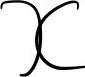

In [148]:
img_name = images[0]
img = cv2.imread(img_name)
bbs = get_character_bounding_boxes(img)
Image.fromarray(extract_bounding_box(img, bbs[0]))

In [149]:
# Get max width and height
max_w = max([bb[2] for bb in bbs])
max_h = max([bb[3] for bb in bbs])

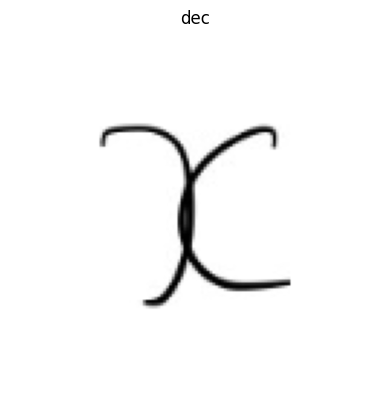

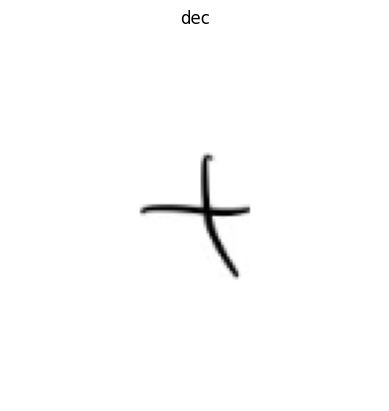

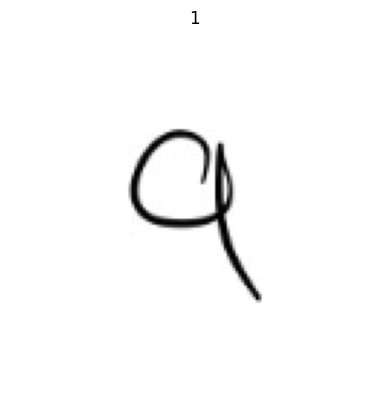

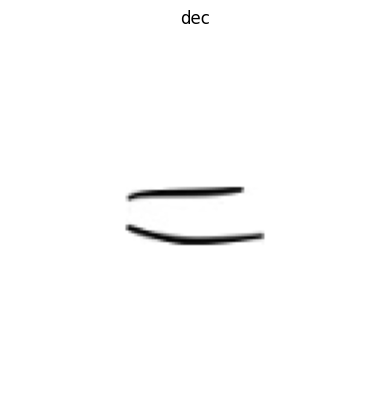

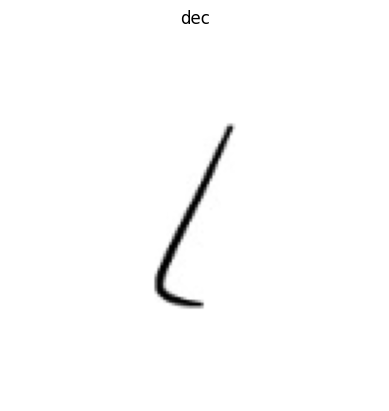

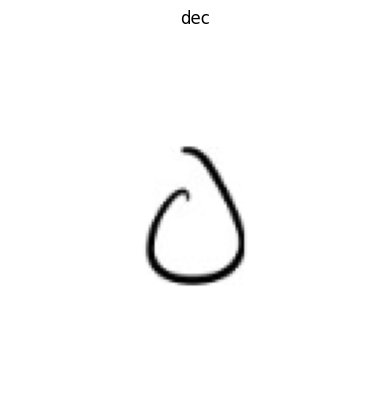

In [157]:
for bb in bbs:
    (x, y, w, h, a) = bb
    char = extract_bounding_box(img, bb)
    pad_width = int((max_w - w) / 2) + 40
    pad_height = int((max_h - h) / 2) + 40
    char = np.pad(char, ((pad_height,pad_height),(pad_width,pad_width)), 'constant', constant_values=(255,255))
    char = cv2.resize(char, (128, 128))
    char = np.expand_dims(char, axis=0)
    char = np.expand_dims(char, axis=0)
    char = torch.from_numpy(char).float()
    pred = model(char)
    # print(rev_mapping[pred.argmax().item()])
    plt.axis('off')
    plt.title(rev_mapping[pred.argmax().item()])
    plt.imshow(char[0][0], cmap='gray')
    plt.show()


In [151]:
char[0][0]

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])